# Lecture 6

* Coordinate ascent algorithm
* Scikit-learn SVM implementation
* SVM implementation from scratch (using SMO algorithm)

Loading necessary libraries:

In [1]:
import numpy as np
import random
import math
import sklearn.datasets as ds

from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import colors
from JSAnimation import IPython_display
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

# Coordinate ascent algorithm

The coordinate ascent algorithm for the function $z = x^2 + y^2 + 2x + xy$ can be implemented as follows:

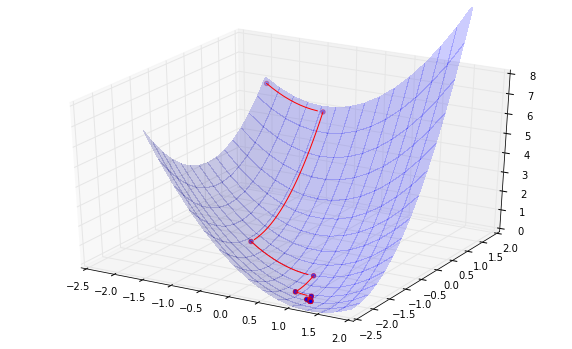

In [2]:
def fun(a,b):
    return a**2 + b**2 + 2*b + a*b

def dfun(a,b,var):
    if var == 0:
        return -b/2.0
    else:
        return - 1.0 - 0.5*a

def coordinate_ascent(theta0, iters):
    history = [np.copy(theta0)] # to store all thetas
    theta = theta0 # initial values for thetas
    for i in range(iters): # number of iterations
        for j in range(2): # number of variables
            theta[j] = dfun(theta[0], theta[1], j)
            history.append(np.copy(theta))
    return history

history = coordinate_ascent(theta0 = [-1.8, 1.6], iters = 7)

fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
plt.hold(True)
a = np.arange(-1.85, 1.85, 0.25)
b = np.arange(-1.85, 1.85, 0.25)
a, b = np.meshgrid(a, b)
c = fun(a,b)
surf = ax.plot_surface(a, b, c, rstride=1, cstride=1, alpha=0.2, 
                       linewidth=0, antialiased=False)
ax.set_zlim(-0.01, 8.01)

a = np.array([x[0] for x in history])
b = np.array([x[1] for x in history])
c = fun(a,b)
ax.scatter(a, b, c, color="r"); 

for i in range(len(history)-1):
    if history[i][0] == history[i+1][0]:
        b = np.arange(history[i][1], history[i+1][1], np.sign(history[i+1][1] - history[i][1])*0.1)
        a = np.ones(len(b)) * history[i][0]
        c = fun(a,b)
        ax.plot(a, b, c, color="r")
    else:
        a = np.arange(history[i][0], history[i+1][0], np.sign(history[i+1][0] - history[i][0])*0.1)
        b = np.ones(len(a)) * history[i][1]
        c = fun(a,b)
        ax.plot(a, b, c, color="r")

plt.show()

# Scikit-learn SVM implementation

There are several implementations of SVM in scikit-learn package: SVC (for classification) and SVR (for regression).

In [3]:
from sklearn.svm import SVC

### XOR problem

As in the previous lecture we try to solve the XOR problem, but this time we are going to use Support Vector Machine for it.

| $\mathbf{x_1}$ | $\mathbf{x_2}$ | XOR $\mathbf{(x_1, x_2)}$ |
|-------|-------|------------------------|
| 1     | 1     |     1 |
| 1     | 0     |     0 |
| 0     | 1     |     0 |
| 0     | 0     |     1 |

The XOR function detects if $x_1$ and $x_2$ are the same. Define our dataset: 4 training examples with XOR as a target variable $y$.

In [4]:
X = np.array([[1, 1], [1, 0], [0, 1], [0, 0]]).astype(np.float64)
y = np.array([1, -1, -1, 1])

Fit the model:

In [7]:
clf = SVC(probability=True, C=100.0, gamma=0.1, kernel='rbf')
clf.fit(X, y) 

SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

We are going to use the function plot\_decision\_boundary() similar to the previous lecture:

In [8]:
def plot_decision_boundary(X, y, model, xmin=-0.1, xmax=1.1, ymin=-0.1, ymax=1.1):
    fig = plt.figure(figsize=(6,6))
    x1, x2 = np.meshgrid(np.linspace(xmin, xmax, 200),
                         np.linspace(ymin, ymax, 200))
    ypred = model.predict_proba(np.c_[x1.ravel(), x2.ravel()])[:,0]
    ypred = ypred.reshape(x1.shape)
    extent = xmin, xmax, ymin, ymax
    
    #plt.imshow(ypred, cmap=cm.bwr, alpha=.9, interpolation='bilinear', extent = extent, origin='lower')
    plt.imshow(ypred, cmap=cm.bwr, alpha=.9, interpolation='bilinear', extent = extent, origin='lower')
    plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=cm.bwr)

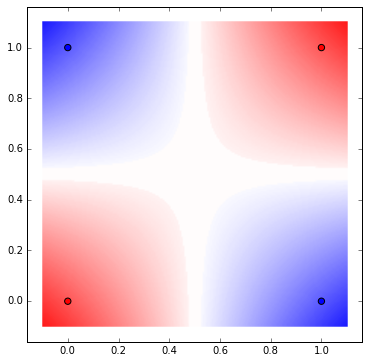

In [9]:
plot_decision_boundary(X, y, clf)

### More complicated data

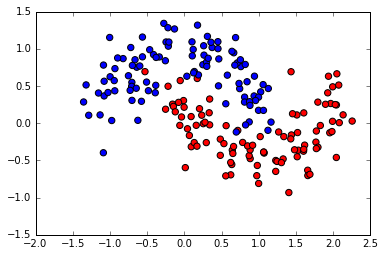

In [10]:
np.random.seed(0)
X, y = ds.make_moons(200, noise=0.20)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=cm.bwr)

In [29]:
clf = SVC(probability=True, C=100.0, gamma=0.1, kernel='rbf')
clf.fit(X, y) 

SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

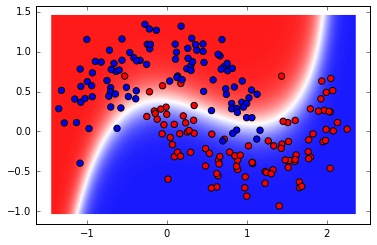

In [30]:
plot_decision_boundary(X, y, clf, xmin=np.min(X[:,0])-0.1, xmax=np.max(X[:,0])+0.1, ymin=np.min(X[:,1])-0.1, ymax=np.max(X[:,1])+0.1)

We can get some useful information from the model, for example, number of support vectors (number of $i$ such that $\alpha_i \neq 0$):

In [31]:
print "Number of support vectors: " + str(len(clf.support_))

Number of support vectors: 51


# SVM implementation from scratch (using SMO algorithm)

In this section we have implemented the simplified version of SMO algorithm (check lecture 6 of references at the end of the lecture 6). First we define the function that calculates a kernel. We are going to use RBF kernel, which means that $\mathbf{K}_{ii} = 1$ for any $i$.

In [3]:
def kernel(x1, x2):
    return np.exp(-np.sum(np.power([i-j for i,j in zip(x1,x2)], 2))/2.0)

When we predict the output for the test dataset, we should calculate the kernel function for each pair (test example, support vector). It becomes very computationally expensive if you use loops for that. I have written the function that use some vectorized operations from numpy:

In [4]:
def h(X, y, alpha, b, Xtest):
    ix = [i for i,a in enumerate(alpha) if a!=0]
    X_magnitude = 0.5*np.sum(np.power(X[ix,:], 2), axis=1)
    Xtest_magnitude = 0.5*np.sum(np.power(Xtest, 2), axis=1)
    dists = np.multiply(np.exp(np.dot(Xtest, np.transpose(X[ix,:])) - np.add.outer(Xtest_magnitude, X_magnitude)), y[ix])
    return np.sum(dists, axis=1) + b

The main function is smo\_step() that takes $X$, $y$, $\alpha$, $b$ and index $j$ as inputs and returns new values $\alpha$ and new value $b$. Notice that if this function fails it returns previous values for $\alpha$ and $b$.

In [5]:
def smo_step(X, y, alpha, b, j):
    Ej = h(X, y, alpha, b, X[j,:].reshape((1,-1)))[0] - y[j]
    if ((y[j]*Ej < -gamma and alpha[j]<C) or (y[j]*Ej > gamma and alpha[j]>0)):
        ilist = [x for x in range(X.shape[0]) if x != j]
        while True:
            if len(ilist) == 0:
                break
            i = random.sample(ilist, 1)[0]
            ilist.remove(i)
            Ei = h(X, y, alpha, b, X[i,:].reshape((1,-1)))[0] - y[i]
            if y[i]*y[j] > 0:
                L = max(0.0, alpha[i] + alpha[j] - C)
                H = min(alpha[i] + alpha[j], C)
            else:
                L = max(0.0, alpha[j] - alpha[j])
                H = min(C + alpha[j] - alpha[i], C)
            if L == H: continue
            Kij = kernel(X[i,:], X[j,:])
            eta = 2.0*Kij - 2.0
            if eta == 0: continue
            alpha_j = np.clip(alpha[j] - y[j]*(Ei - Ej)/eta, L, H)
            if np.abs(alpha_j - alpha[j]) < 0.00001: continue
            alpha_i = alpha[i] + y[i]*y[j]*(alpha[j] - alpha_j)
            if (alpha_j > 0 and alpha_j < C):
                b = b - Ej - y[j]*(alpha_j - alpha[j]) - y[i]*Kij*(alpha_i - alpha[i])
            else:
                if (alpha_i > 0 and alpha_i < C):
                    b = b - Ei - y[j]*Kij*(alpha_j - alpha[j]) - y[i]*(alpha_i - alpha[i])
                else:
                    b = b - 0.5*(Ei + Ej + y[j]*(1.0 + Kij)*(alpha_j - alpha[j]) + y[i]*(1.0 + Kij)*(alpha_i - alpha[i]))
            alpha[i] = alpha_i
            alpha[j] = alpha_j
            break
    return alpha, b

One more auxiliary function plot\_decision\_boundary(). The main difference is that now we are using function h for the prediction.

In [6]:
def plot_decision_boundary(X, y, alpha, b, xmin=-0.1, xmax=1.1, ymin=-0.1, ymax=1.1):
    x1, x2 = np.meshgrid(np.linspace(xmin, xmax, 200),
                         np.linspace(ymin, ymax, 200))
    ypred = np.array(h(X, y, alpha, b, np.c_[x1.ravel(), x2.ravel()]))
    ypred = ypred.reshape(x1.shape)
    extent = xmin, xmax, ymin, ymax
    
    #plt.imshow(ypred, cmap=cm.bwr, alpha=.9, interpolation='bilinear', extent = extent, origin='lower')
    plt.imshow(ypred, cmap=cm.bwr, alpha=.9, interpolation='bilinear', extent = extent, origin='lower')
    plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=cm.bwr)

As an example I have implemented the simple function that returns the number of support vectors:

In [7]:
def support_vector_count(alpha):
    return len([i for i,a in enumerate(alpha) if a!=0])

### XOR problem

In this section we solve XOR problem using our implemented SVM.

In [37]:
X = np.array([[1, 1], [1, 0], [0, 1], [0, 0]]).astype(np.float64)
y = np.array([1, -1, -1, 1])

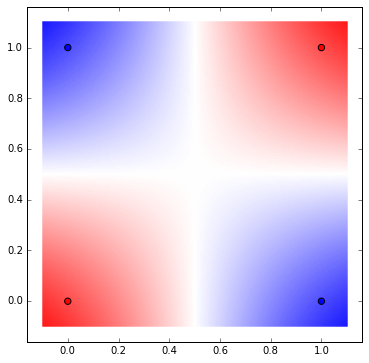

In [38]:
### define the parameters and initialize values for alpha and b
C = 10.0
gamma = 0.1
b = 0.0
alpha = np.zeros(X.shape[0])
niter = 10

### parameters for plotting
fig = plt.figure(figsize=(6,6))

### our main loop
for it in range(niter):
    for j in range(X.shape[0]):
        alpha, b = smo_step(X, y, alpha, b, j)
plot_decision_boundary(X, y, alpha, b, xmin=np.min(X[:,0])-0.1, xmax=np.max(X[:,0])+0.1, ymin=np.min(X[:,1])-0.1, ymax=np.max(X[:,1])+0.1)
plt.show()

In [39]:
print "alpha: " + str(alpha)
print "b: " + str(b)

alpha: [ 10.  10.  10.  10.]
b: -5.55111512313e-17


### More complicated data:

We check our implementation for more complicated data:

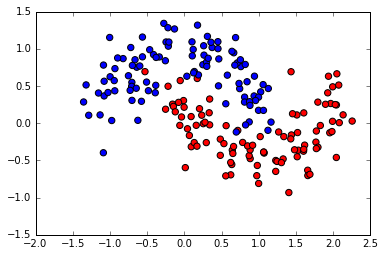

In [8]:
np.random.seed(0)
X, y = ds.make_moons(200, noise=0.20)
y[y==0] = -1
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=cm.bwr)

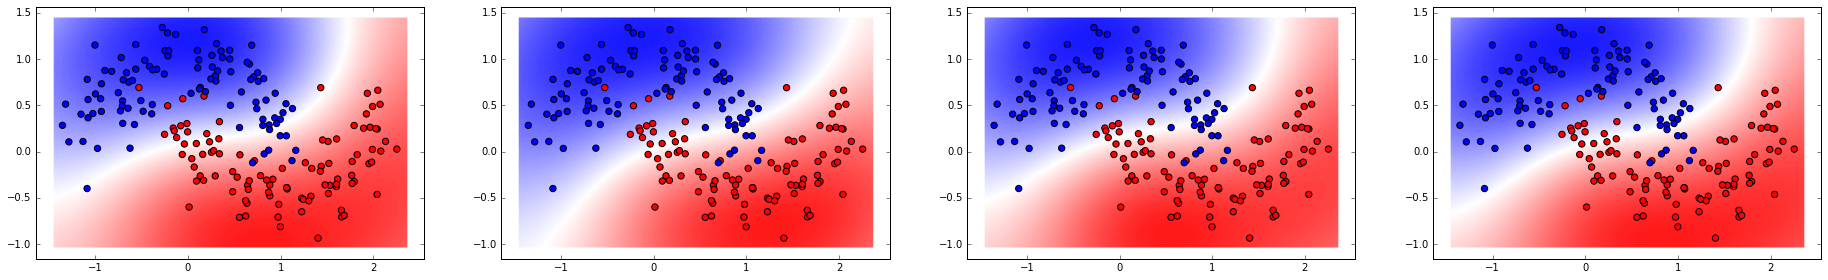

In [14]:
### define the parameters and initialize values for alpha and b
C = 1000.0
gamma = 0.001
b = 0.0
alpha = np.zeros(X.shape[0])
niter = 600

### parameters for plotting
iter_to_plot = [1, niter/3, 2*niter/3, niter-1]
count_plot = 0
fig = plt.figure(figsize=(32,32))

### our main loop
for it in range(niter):
    for j in range(X.shape[0]):
        alpha, b = smo_step(X, y, alpha, b, j)
    if it in iter_to_plot:
        count_plot = count_plot + 1
        fig.add_subplot(1,len(iter_to_plot),count_plot)
        plot_decision_boundary(X, y, alpha, b, xmin=np.min(X[:,0])-0.1, xmax=np.max(X[:,0])+0.1, ymin=np.min(X[:,1])-0.1, ymax=np.max(X[:,1])+0.1)
plt.show()        

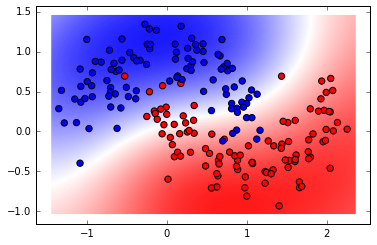

In [15]:
fig = plt.figure(figsize=(6,6))
plot_decision_boundary(X, y, alpha, b, xmin=np.min(X[:,0])-0.1, xmax=np.max(X[:,0])+0.1, ymin=np.min(X[:,1])-0.1, ymax=np.max(X[:,1])+0.1)
plt.show()

In [43]:
print "Number of support vectors: " + str(support_vector_count(alpha))

Number of support vectors: 69


The final remark is that built-in algorithm uses a lot of optimization techniques (for example, it does not choose pair of $\alpha_i$, $\alpha_j$ randomly but utilizes some heuristic for that). As we can see even without these techniques our algorithm gives pretty good result.